## LSTM Training
This notebook sets up a basic LSTM model for use in this project.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Toy Problem
Setting up a toy time series binary classification problem. Generating a dataloader that contains univariate time series that is either linear or log.

In [3]:
def generate_data(length):
    X_data = []
    y_data = []
    
    for i in range(5000):
        eps = np.random.rand(3)
        X_data.append(np.linspace(0+(eps[0]/10), 1+(eps[1]/10), length) * eps[2])
        y_data.append(1)
    
    for i in range(5000):
        eps = np.random.rand(3)
        X_data.append(np.geomspace(0.0000001+(eps[0]/10), 1+(eps[1]/10), length) * eps[2])
        y_data.append(0)
    
    tensor_x = torch.Tensor(X_data).to(device)
    tensor_y = torch.Tensor(y_data).to(device)
    
    return DataLoader(TensorDataset(tensor_x, tensor_y), batch_size=64, shuffle=True)

In [4]:
trainloader = generate_data(500)
example = next(iter(trainloader))
example

/tmp/ipykernel_74835/2063342039.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/torch/csrc/utils/tensor_new.cpp:230.)
  tensor_x = torch.Tensor(X_data).to(device)


[tensor([[0.0779, 0.0799, 0.0819,  ..., 1.0660, 1.0680, 1.0699],
         [0.0044, 0.0044, 0.0044,  ..., 0.0611, 0.0614, 0.0617],
         [0.0320, 0.0334, 0.0348,  ..., 0.7481, 0.7496, 0.7510],
         ...,
         [0.0665, 0.0680, 0.0696,  ..., 0.8460, 0.8476, 0.8491],
         [0.0492, 0.0504, 0.0516,  ..., 0.6414, 0.6426, 0.6438],
         [0.0337, 0.0356, 0.0375,  ..., 0.9753, 0.9772, 0.9791]],
        device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
         1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
         1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
         1., 1., 1., 0., 1., 0., 1., 1., 1., 1.], device='cuda:0')]

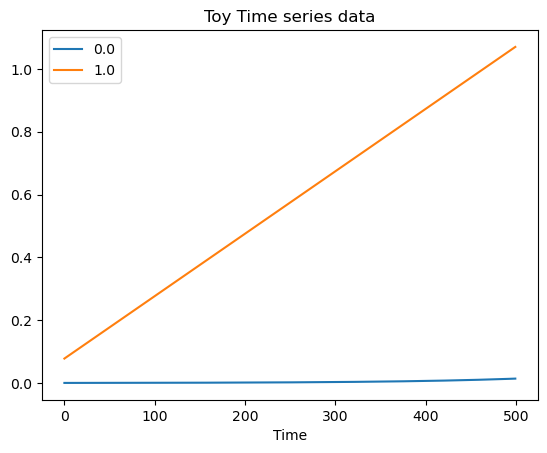

In [5]:
plt.title("Toy Time series data")
plt.plot(example[0][3].cpu(), label=example[1][3].item())
plt.plot(example[0][0].cpu(), label=example[1][0].item())
plt.xlabel("Time")
plt.legend()
plt.show()

### Hyperparameter Config

In [6]:
config = {
    'length': 500,
    'hidden_size': 64
}

### Transformer Model Architecture

In [7]:
class LSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.length = config['length']
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True, bidirectional=True)
        self.classification_head = nn.Linear(self.length*config['hidden_size']*2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.reshape_batch(x)
        z = self.lstm(x)[0]
        z = torch.flatten(z, 1)
        print(z.shape)
        z = self.classification_head(z)
        return self.sigmoid(z).squeeze(1)
    
    def reshape_batch(self, data):
        return data.unsqueeze(2)

In [8]:
lstm = LSTM(config).to(device)
lstm(example[0])

torch.Size([64, 64000])


tensor([0.4970, 0.4983, 0.4974, 0.4983, 0.4982, 0.4983, 0.4981, 0.4983, 0.4982,
        0.4971, 0.4979, 0.4982, 0.4984, 0.4983, 0.4977, 0.4977, 0.4982, 0.4983,
        0.4978, 0.4980, 0.4983, 0.4981, 0.4982, 0.4972, 0.4981, 0.4976, 0.4982,
        0.4979, 0.4983, 0.4984, 0.4981, 0.4983, 0.4971, 0.4977, 0.4980, 0.4979,
        0.4978, 0.4977, 0.4983, 0.4974, 0.4982, 0.4973, 0.4979, 0.4984, 0.4972,
        0.4976, 0.4981, 0.4970, 0.4972, 0.4980, 0.4979, 0.4977, 0.4983, 0.4983,
        0.4976, 0.4980, 0.4977, 0.4983, 0.4981, 0.4981, 0.4972, 0.4972, 0.4975,
        0.4971], device='cuda:0', grad_fn=<SqueezeBackward1>)

### Training Loop

In [9]:
objective = nn.BCELoss()

lstm = LSTM(config).to(device)

lr = 1e-4
n_epochs = 10
optim = torch.optim.Adam(lstm.parameters(), lr=lr)
losses = []

for n in range(n_epochs):
    counter = 0
    for i, (X, y) in enumerate(tqdm(trainloader)):
        optim.zero_grad()
        yhat = lstm(X)
        loss = objective(yhat, y)
        loss.backward()
        losses.append(loss.item())
        optim.step()
        counter += 1
        
    print("Epoch:", n+1, "Loss:",np.mean(losses[-counter:][0]))

RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

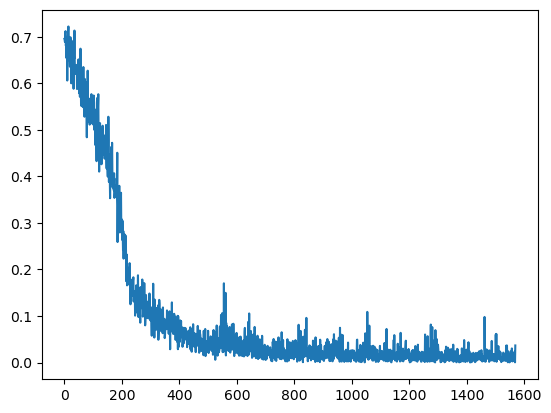

In [30]:
plt.plot(losses)

### Evaluate Training Accuracy

In [31]:
with torch.no_grad():
    correct = 0
    N = 0
    
    for i, (X, y) in enumerate(tqdm(trainloader)):
        probs = lstm(X)
        preds = torch.round(probs)
        
        correct += (preds == y).sum().item()
        N += y.shape[0]
        
    print("Train Accuracy: ", correct/N)

100%|██████████| 157/157 [00:00<00:00, 619.46it/s]

Train Accuracy:  0.9962
